In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import joblib

In [2]:
df_feats = pd.read_csv("features.csv")     # handcrafted + relative paths
df_embeds = pd.read_csv("cnn_embeddings.csv")  # CNN embeddings


X_hand = df_feats.drop(columns=["relpath", "label"]).values
X_cnn = df_embeds.values
y = df_feats["label"].values

# 2️⃣ Reduce CNN embedding size with PCA
pca = PCA(n_components=50, random_state=42)
X_cnn_reduced = pca.fit_transform(X_cnn)

# 3️⃣ Merge features
X = np.hstack([X_hand, X_cnn_reduced]).astype(np.float32)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Step 4: Feature scaling (optional but recommended for some models)
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train).astype(np.float32)
X_test_scaled = scaler.transform(X_test).astype(np.float32)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_scaled, y_train)

In [4]:
pos_weight = (y_resampled == 0).sum() / (y_resampled == 1).sum()


# Train XGBoost Classifier
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'gamma': trial.suggest_float('gamma', 0, 0.5),
        'reg_alpha': trial.suggest_float('reg_alpha', 0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 1, 10),
        'scale_pos_weight': pos_weight,
        'tree_method': 'hist',
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42,
    }
    clf = XGBClassifier(**params)
    scores = cross_val_score(
        clf, X_resampled, y_resampled,
        cv=StratifiedKFold(n_splits=3, shuffle=True, random_state=42),
        scoring='accuracy',
        n_jobs=-1
    )
    return scores.mean()

# 3️⃣ Run Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # adjust n_trials as needed

# 4️⃣ Train best model and evaluate on test set
best_params = study.best_params
best_clf = XGBClassifier(**best_params)
best_clf.fit(X_resampled, y_resampled)
y_pred = best_clf.predict(X_test_scaled)

print("✅ Best hyperparameters:", best_params)

[I 2025-07-26 23:36:55,260] A new study created in memory with name: no-name-9d7d7bee-3198-4bd6-a1ee-4badf922be99


[I 2025-07-26 23:37:10,339] Trial 0 finished with value: 0.9515741049637421 and parameters: {'max_depth': 7, 'learning_rate': 0.19884162633088126, 'subsample': 0.987758490966437, 'colsample_bytree': 0.6149130493534185, 'gamma': 0.019531879819467468, 'reg_alpha': 0.5775968360222922, 'reg_lambda': 1.7515500208288441}. Best is trial 0 with value: 0.9515741049637421.
[I 2025-07-26 23:37:19,545] Trial 1 finished with value: 0.9149971614020918 and parameters: {'max_depth': 5, 'learning_rate': 0.015586810125005733, 'subsample': 0.702416757034543, 'colsample_bytree': 0.9845372977401772, 'gamma': 0.3670622203862981, 'reg_alpha': 0.018489161812918375, 'reg_lambda': 2.0913073058856804}. Best is trial 0 with value: 0.9515741049637421.
[I 2025-07-26 23:37:28,450] Trial 2 finished with value: 0.9446502671793701 and parameters: {'max_depth': 8, 'learning_rate': 0.09313039131757622, 'subsample': 0.9935830148172462, 'colsample_bytree': 0.8237390426165474, 'gamma': 0.43465462189741116, 'reg_alpha': 0.82

✅ Best hyperparameters: {'max_depth': 5, 'learning_rate': 0.19617732848126002, 'subsample': 0.8571406462414759, 'colsample_bytree': 0.8143600489304117, 'gamma': 0.03249357194593136, 'reg_alpha': 0.0006629487154761193, 'reg_lambda': 3.3447873762550975}


In [5]:
print("✅ Model Evaluation Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

✅ Model Evaluation Results:
Accuracy: 0.9507389162561576

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94        77
           1       0.96      0.96      0.96       126

    accuracy                           0.95       203
   macro avg       0.95      0.95      0.95       203
weighted avg       0.95      0.95      0.95       203



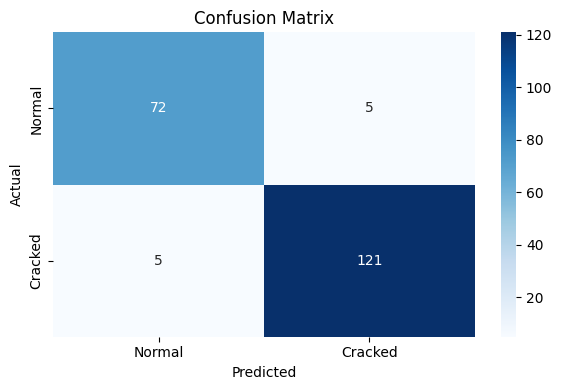

In [6]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Cracked"], yticklabels=["Normal", "Cracked"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [7]:
joblib.dump(scaler, "scaler.pkl")
joblib.dump(pca, "pca.pkl")
joblib.dump(best_clf, "xgb_model.pkl")

['xgb_model.pkl']